<h1><center>RSNA Screening Mammography Breast Cancer Detection. Part 1 - EDA</center></h1>

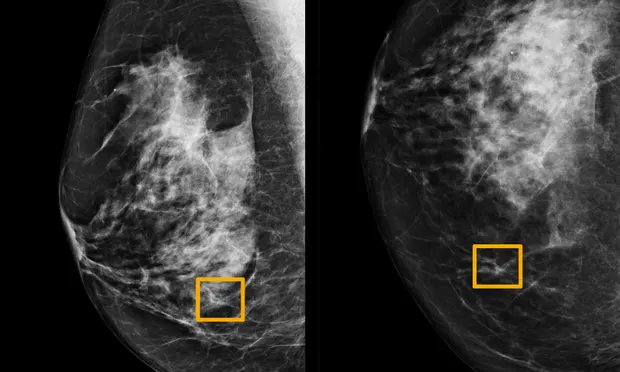

# Table of contents

* [Overview](#Overview)
* [Installing and importing necessary dependancies](#dependancies)
* [Data cleaning and exploratory analysis](#eda)
    * [Hndling Missing values](#missing_vals)
    * [Handling numerical features](#features)
    * [Handling categorical features](#features)
    * [Target features](#target_features)
* [Exploring the images](#images)
    * [Inspecting dicom files](#dicom)
    * [Pixelarray distributions](#raw_values)
    * [Background values and image sizes](#mid_dependence)
    * [Exploring dicom images](#mid_images)
    * [Exploring images showing cancer](#cancer)
* [Conclusion](#conclusion)

## Overview
### What is breast cancer?

Breast cancer is cancer that forms in the cells of the breasts.

After skin cancer, breast cancer is the most common cancer diagnosed in women in the United States. Breast cancer can occur in both men and women, but it's far more common in women.

Substantial support for breast cancer awareness and research funding has helped create advances in the diagnosis and treatment of breast cancer. Breast cancer survival rates have increased, and the number of deaths associated with this disease is steadily declining, largely due to factors such as earlier detection, a new personalized approach to treatment and a better understanding of the disease.

### Risk factors

A breast cancer risk factor is anything that makes it more likely you'll get breast cancer. But having one or even several breast cancer risk factors doesn't necessarily mean you'll develop breast cancer. Many women who develop breast cancer have no known risk factors other than simply being women.

Factors that are associated with an increased risk of breast cancer include:

**Being female.** Women are much more likely than men are to develop breast cancer.

**Increasing age.** Risk of breast cancer increases as age.

**A personal history of breast conditions.** Had a breast biopsy that found lobular carcinoma in situ (LCIS) or atypical hyperplasia of the breast, you have an increased risk of breast cancer.

**A personal history of breast cancer.** Had breast cancer in one breast, have an increased risk of developing cancer in the other breast.

**A family history of breast cancer.** mother, sister or daughter was diagnosed with breast cancer, particularly at a young age, risk of breast cancer is increased. Still, the majority of people diagnosed with breast cancer have no family history of the disease.

**Inherited genes that increase cancer risk.** Certain gene mutations that increase the risk of breast cancer can be passed from parents to children. The most well-known gene mutations are referred to as BRCA1 and BRCA2. These genes can greatly increase your risk of breast cancer and other cancers, but they don't make cancer inevitable.

**Radiation exposure.** received radiation treatments to chest as a child or young adult, the risk of breast cancer is increased.

**Obesity.** Being obese increases risk of breast cancer.

**Beginning period at a younger age.** Beginning period before age 12 increases risk of breast cancer.
**Beginning menopause at an older age.** began menopause at an older age, more likely to develop breast cancer.
**Having first child at an older age.** Women who give birth to their first child after age 30 may have an increased risk of breast cancer.

**Having never been pregnant.** Women who have never been pregnant have a greater risk of breast cancer than do women who have had one or more pregnancies.

**Postmenopausal hormone therapy.** Women who take hormone therapy medications that combine estrogen and progesterone to treat the signs and symptoms of menopause have an increased risk of breast cancer. The risk of breast cancer decreases when women stop taking these medications.

**Drinking alcohol.** Drinking alcohol increases the risk of breast cancer.

## Context and Goal of the Competition

The competition host, the Radiological Society of North America (RSNA) is a non-profit organization that represents 31 radiologic subspecialties from 145 countries around the world. RSNA promotes excellence in patient care and health care delivery through education, research, and technological innovation.

The goal of this competition is to identify breast cancer. The model will be trained with screening mammograms obtained from regular screening.

Improving the automation of detection in screening mammography may enable radiologists to be more accurate and efficient, improving the quality and safety of patient care. It could also help reduce costs and unnecessary medical procedures.

## Installing and importing necessary dependancies

In [1]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.0 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np

import pydicom
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_color_codes('bright')
import plotly.express as px
from tqdm import tqdm

from PIL import Image
import cv2
import glob
from joblib import Parallel, delayed

from scipy.stats import mode, skew

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import math
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Exploring the Data

Let's read the 'train.csv' file. 

In [3]:
train_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
train_df.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [4]:
train_df.shape

(54706, 14)

In [5]:
test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df.head()

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id  
0       10008_L  
1       10008_L  
2       10008_R  
3       10008_R

In [6]:
test_df.shape

(4, 9)

There is 54706 rows and 14 columns for trainset and only 4 rows and 9 columns for test set, that's mean there is a lot of difference between the two datasets, but before starting the exploration of the two dataframes, starting first with the description of each feature keyword.

### Explanation of feature keywords

**Laterality:** Laterality describes which side of a paired organ is the origin of the primary cancer. Each side of a paired organ is considered separately and described as lateral when occurring unless a physician determines that it is bilateral.

A paired organ is one in which there are two separate organs of the same kind, one on either side of the body (e.g. kidney, breast, ovary, testis and lung).

**View:** In screening digital mammography, each breast is typically imaged with two different views, i.e., the mediolateral oblique (MLO) view and cranial caudal (CC) view. The MLO view is taken from the center of the chest outward, while the CC view is taken from above the breast.
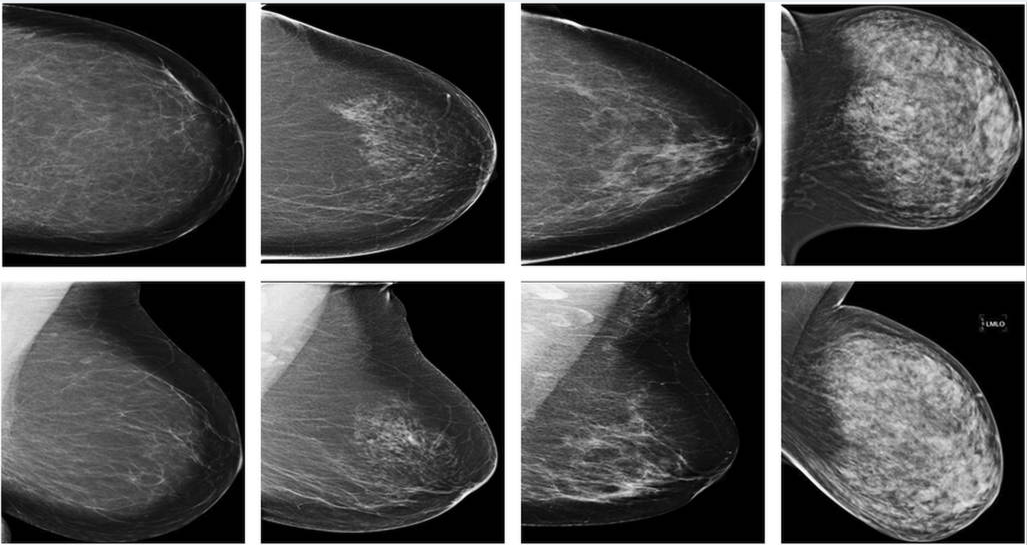
*Examples of the mediolateral oblique (MLO) view (row 1) and cranial caudal (CC) view (row 2) digital mammogram images, illustrating the four qualitative Breast Imaging and Reporting Data System (BI-RADS) breast density categories, i.e., fatty (column 1), scattered density (column 2), heterogeneously dense (column 3), and extremely dense (column 4)*

**Implant:** A silicone gel-filled or saline-filled sac placed under the chest muscle to restore breast shape. Breast implants have been linked with some rare types of cancer, which can develop in the scar tissue (capsule) around the implant.

For example, breast implant-associated anaplastic large cell lymphoma (BIA-ALCL) is a rare type of non-Hodgkin lymphoma that can develop several years after the implant is placed.

**Biopsy:** The removal of cells or tissues for examination by a pathologist. The pathologist may study the tissue under a microscope or perform other tests on the cells or tissue. There are many different types of biopsy procedures. The most common types include: (1) incisional biopsy, in which only a sample of tissue is removed; (2) excisional biopsy, in which an entire lump or suspicious area is removed; and (3) needle biopsy, in which a sample of tissue or fluid is removed with a needle. When a wide needle is used, the procedure is called a core biopsy. When a thin needle is used, the procedure is called a fine-needle aspiration biopsy.

**Invasive:** Cancer that has spread from where it began in the breast to surrounding normal tissue.

**BIDARS:** The BI-RADS score is an acronym for the Breast Imaging Reporting and Database System score. It’s a scoring system radiologists use to describe mammogram results.

A mammogram is an X-ray imaging test that examines breast health. It’s the most efficient tool to help detect breast cancer, especially at its earliest stage. It can also be used as a follow-up tool when doctors find abnormal masses during a clinical breast exam.

While this test can’t medically diagnose breast cancer, it can help identify anything abnormal. Not all abnormal findings are considered cancerous. Doctors use the BI-RADS system to place abnormal findings into categories. The categories are from 0 to 6. Oftentimes, women 40 years and older receive scores ranging from 0 to 2, indicating normal results or that abnormal results are benign, or noncancerous. If you receive a score of 3 or above, doctors and radiologists recommend a follow-up visit or a biopsy to determine the next course of action.

**Density:** Breast density reflects the amount of fibrous and glandular tissue in a woman’s breasts compared with the amount of fatty tissue in the breasts, as seen on a mammogram.

On a mammography report, breast density is assigned to one of the following four categories—

The breasts are almost entirely fatty (about 10% of women).
A few areas of dense tissue are scattered through the breasts (about 40% of women).
The breasts are evenly dense throughout (about 40% of women).
The breasts are extremely dense (about 10% of women).
Women in the first two categories are said to have low-density, non-dense, or fatty breasts. Women in the second two categories are said to have high-density or dense breasts. About half of women who are 40 years old or older have dense breasts.

Breast Cancer Risk
Women with dense breasts have a higher chance of getting breast cancer. The more dense your breasts are, the higher your risk. Scientists don’t know for sure why this is true.

Breast cancer patients who have dense breasts are not more likely to die from breast cancer than patients with non-dense (fatty) breasts.

# Exploratory Data Analysis.

## Dataset analysis

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [8]:
train_df.describe()

site_id    patient_id      image_id           age        cancer  \
count  54706.000000  54706.000000  5.470600e+04  54669.000000  54706.000000   
mean       1.460407  32698.865262  1.079386e+09     58.543928      0.021168   
std        0.498434  18893.861534  6.183269e+08     10.050884      0.143944   
min        1.000000      5.000000  6.849100e+04     26.000000      0.000000   
25%        1.000000  16481.000000  5.458153e+08     51.000000      0.000000   
50%        1.000000  32432.000000  1.082689e+09     59.000000      0.000000   
75%        2.000000  48999.000000  1.613228e+09     66.000000      0.000000   
max        2.000000  65534.000000  2.147472e+09     89.000000      1.000000   

             biopsy      invasive        BIRADS       implant    machine_id  
count  54706.000000  54706.000000  26286.000000  54706.000000  54706.000000  
mean       0.054272      0.014953      0.772350      0.026999     54.618378  
std        0.226556      0.121365      0.590062      0.162081     44.784800  
min        0.000000      0.000000      0.000000      0.000000     21.000000  
25%        0.000000      0.000000      0.000000      0.000000     29.000000  
50%        0.000000      0.000000      1.000000      0.000000     49.000000  
75%        0.000000      0.000000      1.000000      0.000000     49.000000  
max        1.000000      1.000000      2.000000      1.000000    216.000000

As explain previously, there is a difference in columns between the testset and the trainset. let's explore the differences.

In [9]:
def compare(df1, df2):
    """Compare two dataframes.

    Args:
        df1: dataframe 1.
        df2: dataframe 2.
        
    """
    L_1 = list(df1.columns)
    L_2 = list(df2.columns)

    print(10*"=","Elements in trainset but absent in testset", 10*"=")
    print(list(set(L_1)-set(L_2)))
    print()
    print(10*"=","Elements in testset but absent in trainset", 10*"=")
    print(list(set(L_2)-set(L_1)))

In [10]:
compare(train_df, test_df)

========== Elements in trainset but absent in testset ==========
['density', 'invasive', 'cancer', 'biopsy', 'BIRADS', 'difficult_negative_case']

========== Elements in testset but absent in trainset ==========
['prediction_id']


Let's plot a histogram for each numerical attribute.

In [11]:
object_f = ['site_id', 'patient_id', 'image_id']
train_df[object_f] = train_df[object_f].astype(object)

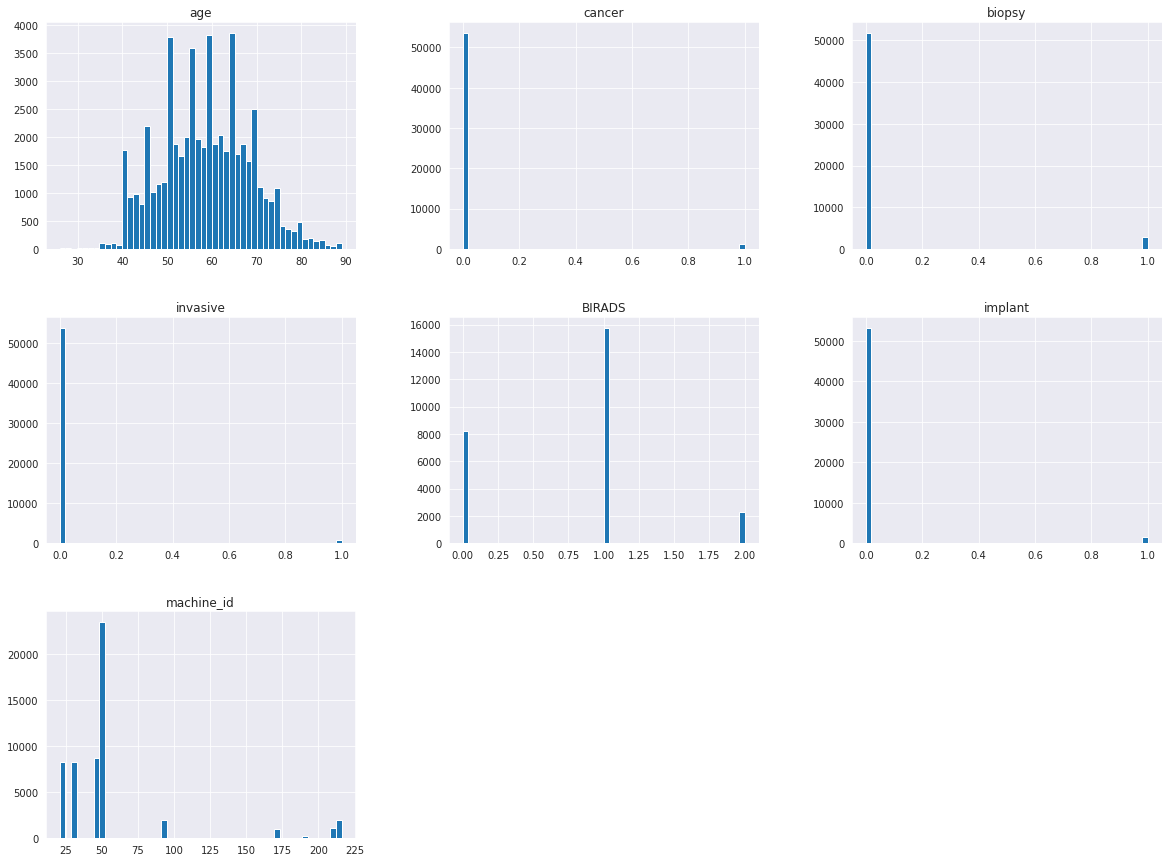

In [12]:
# A histogram for each numerical attribute.
train_df.hist(bins=50, figsize=(20,15))
plt.show()

## Data cleaning and exploratory analysis

### Data cleaning: Handling missing values

<AxesSubplot:>

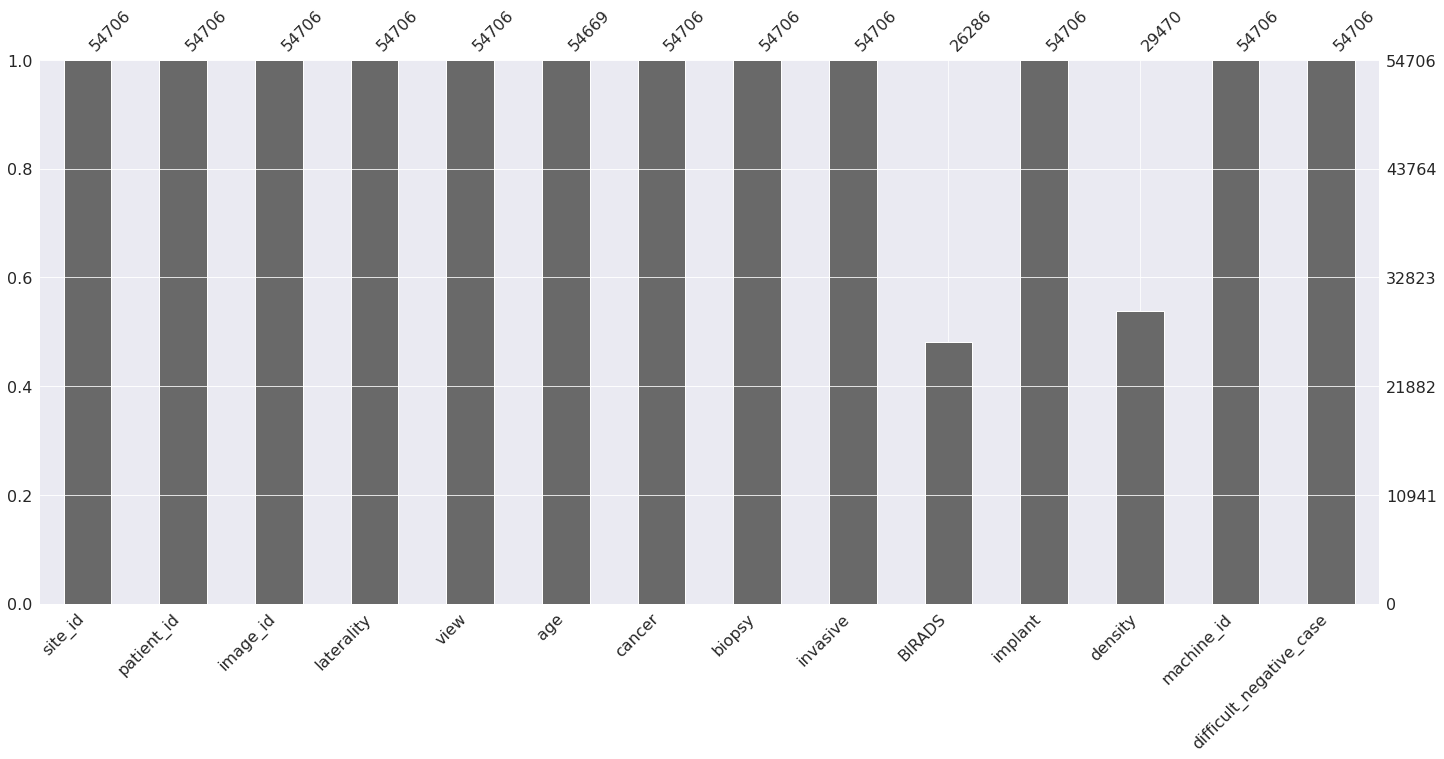

In [13]:
# Visualize the number of missing
# values as a bar chart
msno.bar(train_df)

Let's calculate the percentage of the missing value in each column dataset.

In [14]:
def nan_check(df):
    """list the percentage of NaNs in each column of dataframe.

    Args:
        df: the dataframe.
        
    """

    (df.isna().sum() / df.shape[0]).sort_values(ascending=True)
    print (df.isna().sum() / df.shape[0]
           * 100).sort_values(ascending=True)

In [15]:
nan_check(train_df)

site_id                     0.000000
patient_id                  0.000000
image_id                    0.000000
laterality                  0.000000
view                        0.000000
cancer                      0.000000
biopsy                      0.000000
invasive                    0.000000
implant                     0.000000
machine_id                  0.000000
difficult_negative_case     0.000000
age                         0.067634
density                    46.130223
BIRADS                     51.950426
dtype: float64


We have to handle missing values for the age,density and BIRADS. 

<AxesSubplot:>

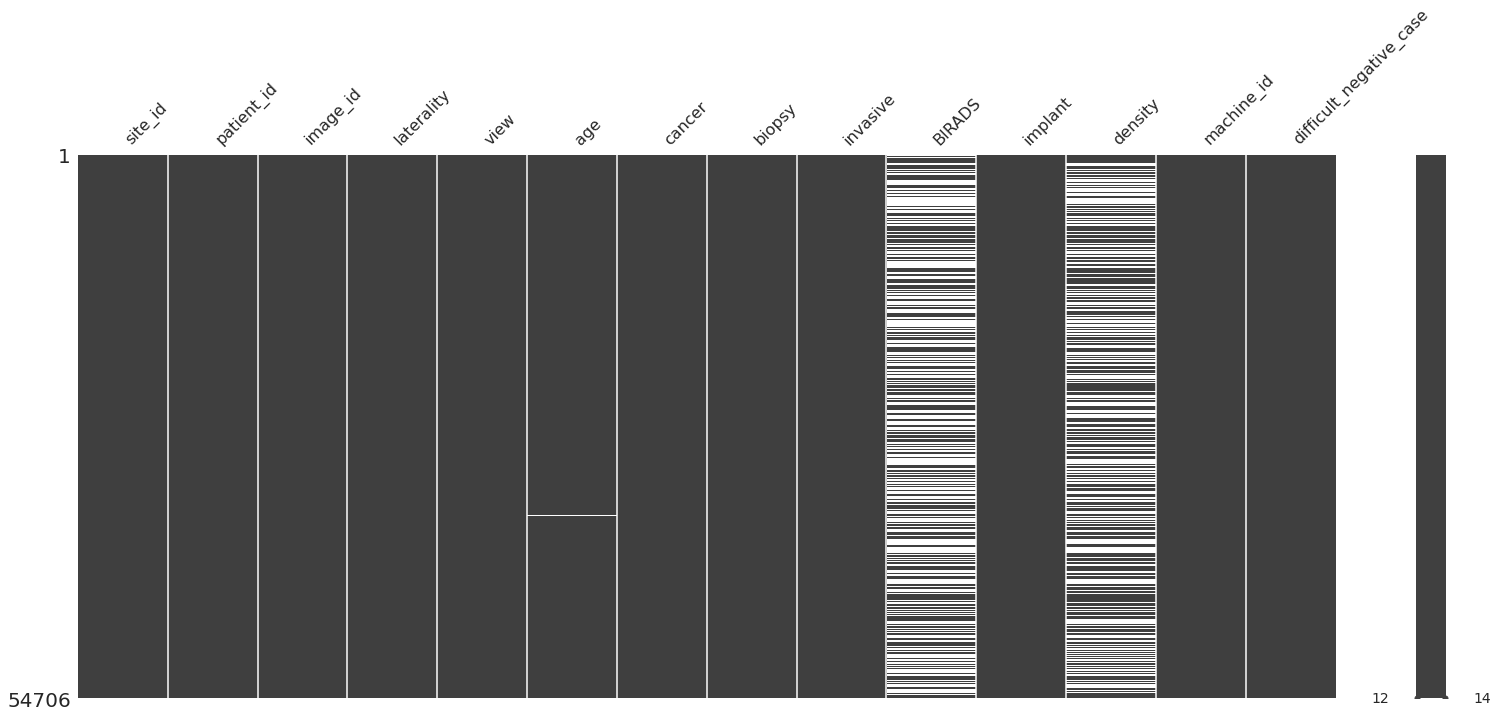

In [16]:
# Visualize missing values as a matrix
msno.matrix(train_df)

Using this matrix we can very quickly find the pattern of missingness in the dataset. In our dataset, the columns BIRADS and Density have a approximately similar pattern of missing values while Age shows a different pattern.

<AxesSubplot:>

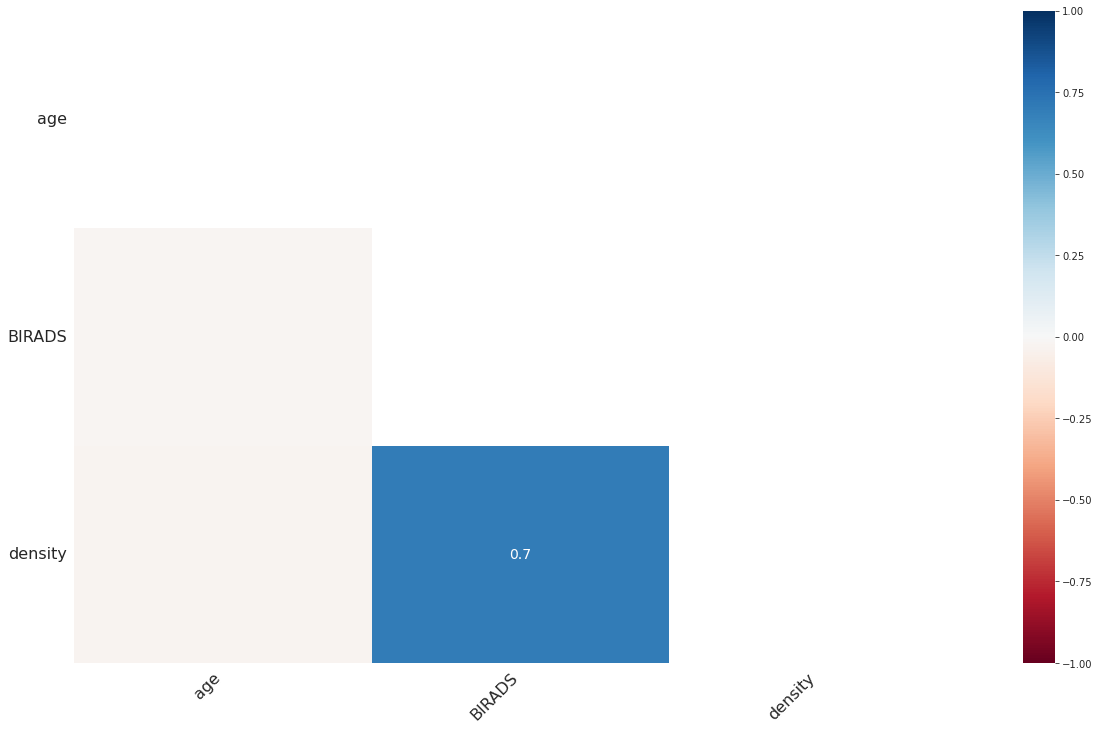

In [17]:
# Visualize the correlation between the number of
# missing values in different columns as a heatmap
msno.heatmap(train_df)

Heatmap shows the correlation of missingness between every 2 columns:

- A value near -1 means if one variable appears then the other variable is very likely to be missing.
- A value near 0 means there is no dependence between the occurrence of missing values of two variables.
- A value near 1 means if one variable appears then the other variable is very likely to be present.

The dendrogram allows us to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:

<AxesSubplot:>

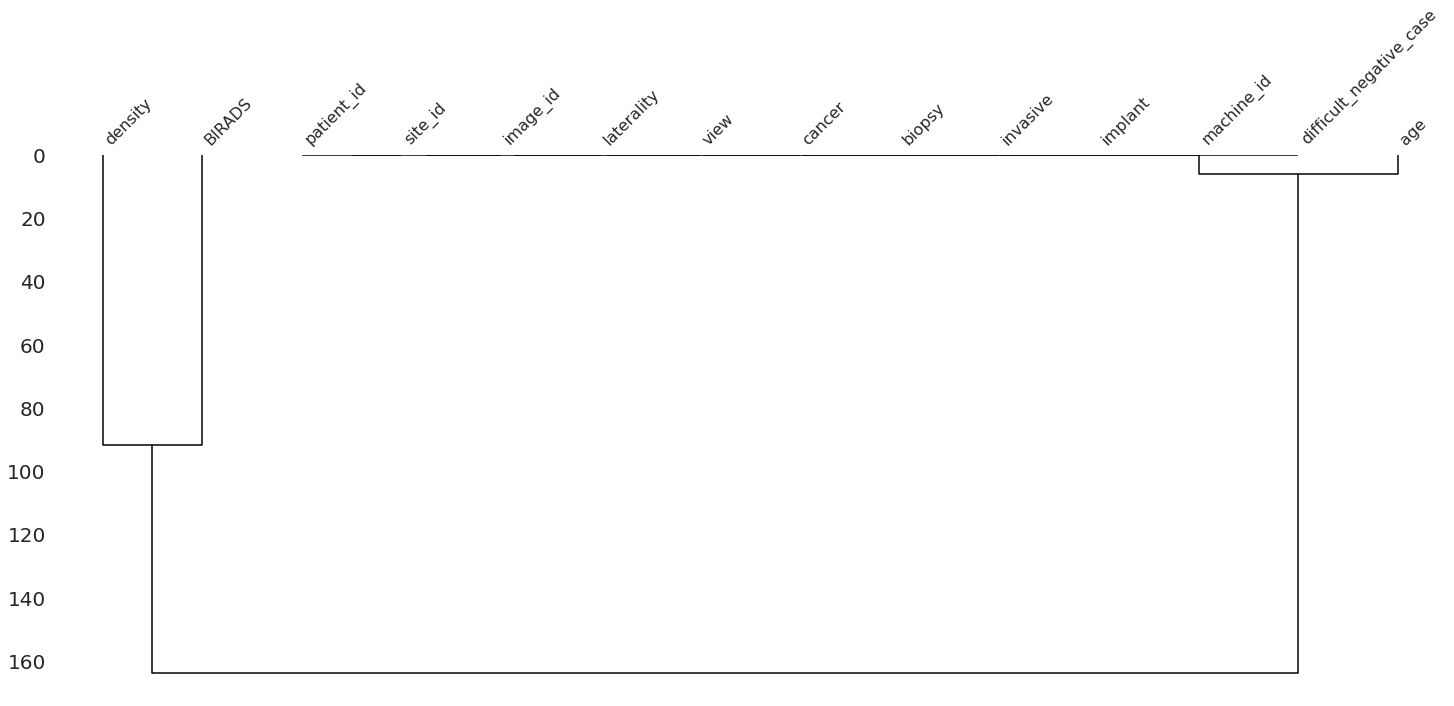

In [18]:
# Visualize the correlation between variables with dendrogram
msno.dendrogram(train_df)

Without going too far in the analysis of missing values and the mechanism that manages them. We assume in this project and this context that the missing values are **Missing At Random (MAR).**

But it is necessary to understand why certain values are missing. 

In [19]:
age_nan_df = train_df[train_df['age'].isna()]

In [20]:
age_nan_df

site_id patient_id    image_id laterality view  age  cancer  biopsy  \
1850        1      11995  1129509810          L   CC  NaN       0       0   
1851        1      11995  1732220752          L  MLO  NaN       0       0   
1852        1      11995   776998051          R  MLO  NaN       0       0   
1853        1      11995  2123005479          R   CC  NaN       0       0   
12886       1      23752  1081106657          L   CC  NaN       0       0   
12887       1      23752  1106722394          L  MLO  NaN       0       0   
12888       1      23752   707585829          R  MLO  NaN       0       0   
12889       1      23752  1982432589          R   CC  NaN       0       0   
16230       1      27212   598973621          L  MLO  NaN       0       0   
16231       1      27212   660603973          L   CC  NaN       0       0   
16232       1      27212   727784450          R   CC  NaN       0       0   
16233       1      27212   900539670          R  MLO  NaN       0       0   
28826       1      40791   764475011          L   CC  NaN       0       0   
28827       1      40791  1101107358          L  MLO  NaN       0       0   
28828       1      40791  1771655552          L   CC  NaN       0       0   
28829       1      40791   554095043          R   CC  NaN       0       0   
28830       1      40791   568335050          R  MLO  NaN       0       0   
33450       1      45891    80154231          L  MLO  NaN       0       0   
33451       1      45891   455001902          L  MLO  NaN       0       0   
33452       1      45891   776744820          L   CC  NaN       0       0   
33453       1      45891  1079326337          R  MLO  NaN       0       0   
33454       1      45891  1830737748          R   CC  NaN       0       0   
33455       1      45891  2104208292          R  MLO  NaN       0       0   
35195       1      47764   240900538          L  MLO  NaN       0       0   
35196       1      47764   514059209          L   CC  NaN       0       0   
35197       1      47764  1000923169          L  MLO  NaN       0       0   
35198       1      47764   232534924          R   CC  NaN       0       0   
35199       1      47764  1344437814          R  MLO  NaN       0       0   
36350       1      49020  1309042956          L  MLO  NaN       0       0   
36351       1      49020  1352114614          L  MLO  NaN       0       0   
36352       1      49020  1404451163          L   CC  NaN       0       0   
36353       1      49020   863721443          R   CC  NaN       0       0   
36354       1      49020  1299851146          R  MLO  NaN       0       0   
38567       1      51500   955012081          L  MLO  NaN       0       0   
38568       1      51500  1155043753          L   CC  NaN       0       0   
38569       1      51500   683986533          R   CC  NaN       0       0   
38570       1      51500  1335870954          R  MLO  NaN       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
1850          0     1.0        0       D          49                    False  
1851          0     1.0        0       D          49                    False  
1852          0     1.0        0       D          49                    False  
1853          0     1.0        0       D          49                    False  
12886         0     1.0        0       C          49                    False  
12887         0     1.0        0       C          49                    False  
12888         0     1.0        0       C          49                    False  
12889         0     1.0        0       C          49                    False  
16230         0     NaN        0       D          49                    False  
16231         0     NaN        0       D          49                    False  
16232         0     0.0        0       D          49                     True  
16233         0     0.0        0       D          49                     True  
28826         0     2.0        0       

In [21]:
# Get the patient_id with age with nan.
age_nan_df.groupby('patient_id').first()

site_id    image_id laterality view  age  cancer  biopsy  \
patient_id                                                             
11995             1  1129509810          L   CC  NaN       0       0   
23752             1  1081106657          L   CC  NaN       0       0   
27212             1   598973621          L  MLO  NaN       0       0   
40791             1   764475011          L   CC  NaN       0       0   
45891             1    80154231          L  MLO  NaN       0       0   
47764             1   240900538          L  MLO  NaN       0       0   
49020             1  1309042956          L  MLO  NaN       0       0   
51500             1   955012081          L  MLO  NaN       0       0   

            invasive  BIRADS  implant density  machine_id  \
patient_id                                                  
11995              0     1.0        0       D          49   
23752              0     1.0        0       C          49   
27212              0     0.0        0       D          49   
40791              0     2.0        0       C          49   
45891              0     0.0        0       C          49   
47764              0     0.0        0       C          49   
49020              0     1.0        0       B          49   
51500              0     1.0        0       B          49   

            difficult_negative_case  
patient_id                           
11995                         False  
23752                         False  
27212                         False  
40791                         False  
45891                         False  
47764                         False  
49020                         False  
51500                         False

We know that **age** is an important feature, it would be useful to understand why it is not filled in?

There are some commonalities for these patients:
- No cancer, no biopsy.
- Same Laterlility: L
- no implants
- same machine id.

## Handling numerical features

### Checking for negative or abnormal values.

There are quantities which do not admit of having negative values. We will check that.

In [22]:
train_df.select_dtypes(np.number).min()

age           26.0
cancer         0.0
biopsy         0.0
invasive       0.0
BIRADS         0.0
implant        0.0
machine_id    21.0
dtype: float64

In [23]:
train_df.select_dtypes(np.number).max()

age            89.0
cancer          1.0
biopsy          1.0
invasive        1.0
BIRADS          2.0
implant         1.0
machine_id    216.0
dtype: float64

There are no abnormal values.

### Handling categorical features

In [24]:
# The list of features (object types)
train_df.select_dtypes(['object']).nunique().sort_values(ascending=False)

image_id      54706
patient_id    11913
view              6
density           4
site_id           2
laterality        2
dtype: int64

In [25]:
# The unique components for each variable are displayed. 
for col in train_df.select_dtypes('object'):
    print(f'{col :-<40} {train_df[col].unique()}')  

site_id--------------------------------- [2 1]
patient_id------------------------------ [10006 10011 10025 ... 997 9973 9989]
image_id-------------------------------- [462822612 1459541791 1864590858 ... 1078943060 398038886 439796429]
laterality------------------------------ ['L' 'R']
view------------------------------------ ['CC' 'MLO' 'ML' 'LM' 'AT' 'LMO']
density--------------------------------- [nan 'C' 'D' 'B' 'A']


### Exploratory Data analysis.</font>

#### Detecting outliers <a class="anchor" id="patients"></a>

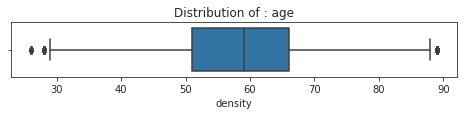

In [26]:
sns.set_style("ticks")
plt.figure(figsize = (8,1))
    
sns.boxplot(x=train_df['age'])
titre = 'Distribution of : ' + "age"
plt.title(titre)
plt.xlabel(col)
plt.show()
sns.set(font_scale=1)  

We note that there are 3 outliers, an 89-year-old patient and 2 patients under 30 years old.

### Distribution of Age

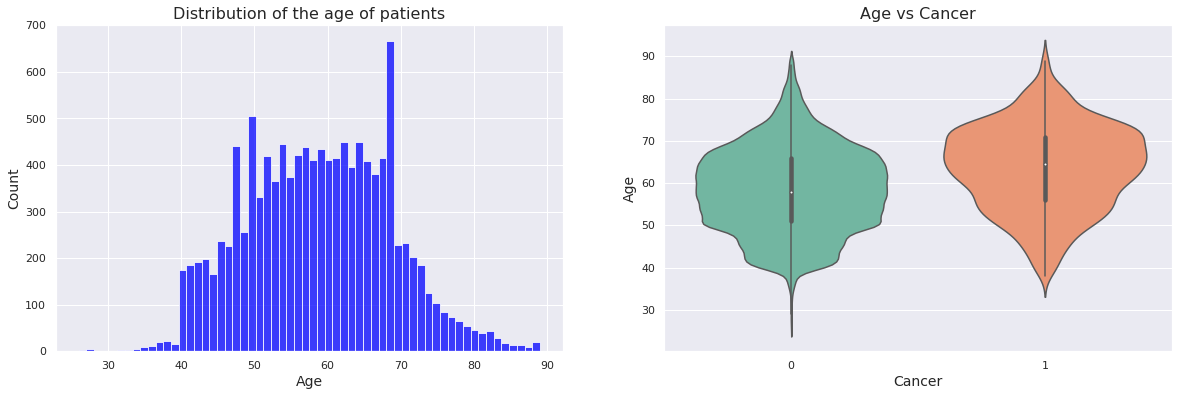

In [27]:
unique_age = train_df[train_df.age.isnull()
                      == False].groupby('patient_id').age.first()

(fig, ax) = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(unique_age, color='blue', bins=60, ax=ax[0])
ax[0].set_xlabel('Age', size=14)
ax[0].set_ylabel('Count', size=14)
ax[0].set_title('Distribution of the age of patients', size=16)

sns.violinplot(train_df.cancer, train_df.age, ax=ax[1], palette='Set2')
ax[1].set_xlabel('Cancer', size=14)
ax[1].set_ylabel('Age', size=14)
ax[1].set_title('Age vs Cancer', size=16)

* Most of the patients are older than 40 years. 
* It seems that we have 2 peaks around the age of 50 and the age of 70. 
* There is a drop of patients counts after the age of 70. 
* For patients with cancer it's more likely that they are older and above the age of 50. 

### Distribution of Cancer

In [28]:
def has_cancer(f):
    """determine if cancer or not.

    Args:
        f: function.
    Returns:
        boolean: True or false.
        
    """
    if len(f) == 1:
        if f[0] == 0:
            return False
        elif f[0] == 1:
            return True
        else:
            raise Exception
    elif len(f) == 2:
        return True
    else:
        raise Exception


patient_cancer_map = train_df.groupby('patient_id'
        ).cancer.unique().apply(lambda f: has_cancer(f))

Text(0, 0.5, 'Count')

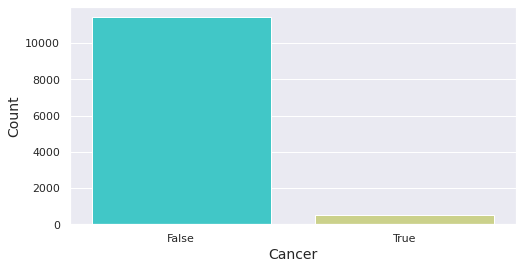

In [29]:
plt.figure(figsize=(8,4))
ax = sns.countplot(patient_cancer_map, palette='rainbow')
ax.set_xlabel("Cancer", size=14)
ax.set_ylabel("Count", size=14)

It's clear that we are in front of an imbalanced classification problem.

### Distribution of Image per patient

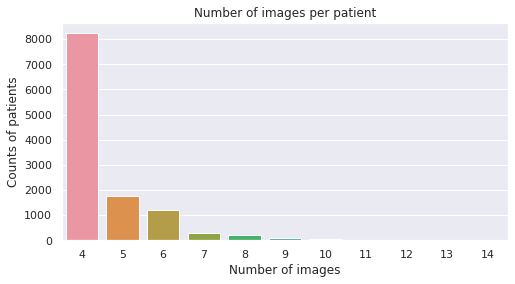

In [30]:
plt.figure(figsize=(8,4))

ax = sns.countplot(train_df.groupby('patient_id').size())
ax.set_title('Number of images per patient')
ax.set_xlabel('Number of images')
ax.set_ylabel('Counts of patients');


In most cases we have 4 images per patient but there are a few cases with more than 10 images.

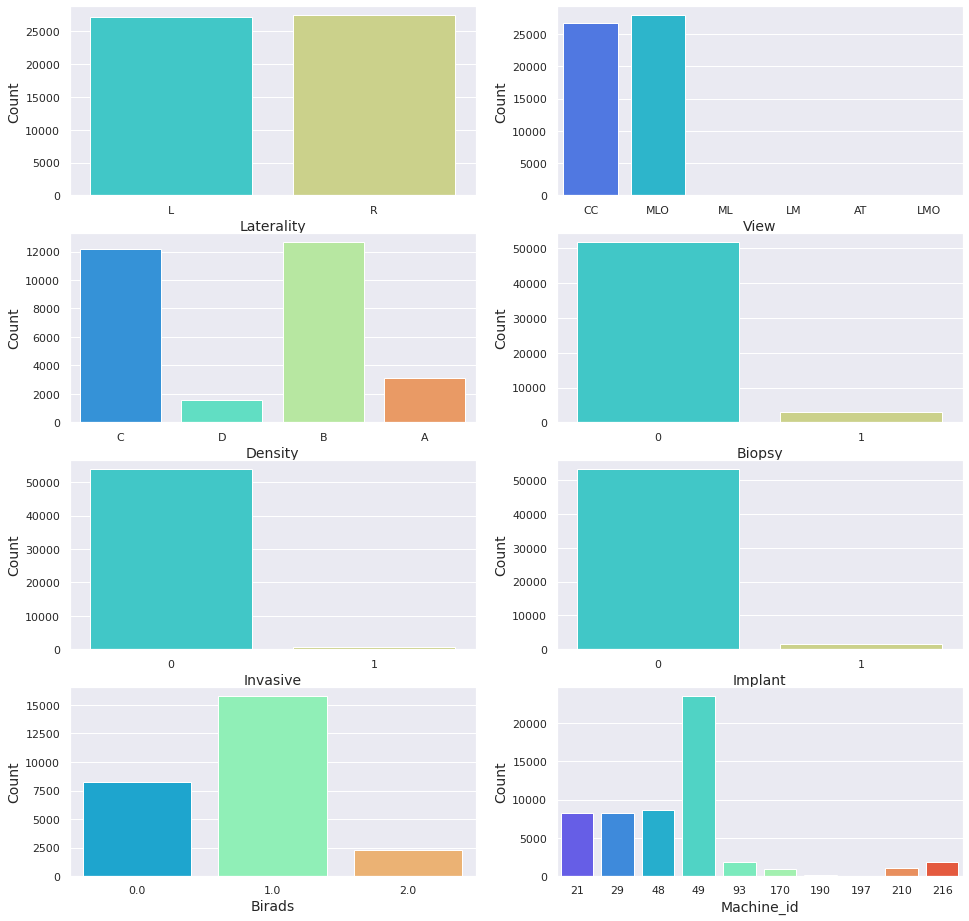

In [31]:
features = [
    'laterality',
    'view',
    'density',
    'biopsy',
    'invasive',
    'implant',
    'BIRADS',
    'machine_id',
    ]
plt.figure(figsize=(16, 16))
for (i, col) in enumerate(features):
    ax = plt.subplot(4, 2, i + 1)
    ax = sns.countplot(x=col, data=train_df[train_df[col].isnull()
                       == False], palette='rainbow')
    ax.set_xlabel(col.capitalize(), size=14)
    ax.set_ylabel('Count', size=14)

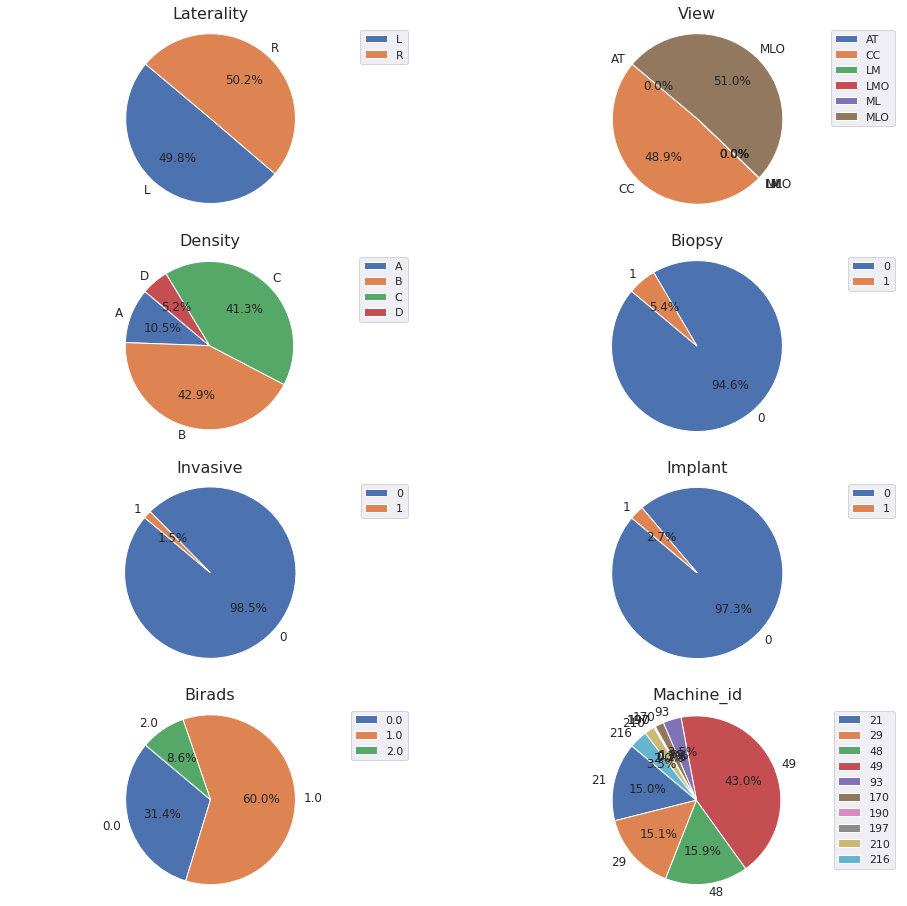

In [32]:
plt.figure(figsize=(16, 16))
for (i, col) in enumerate(features):
    data = train_df[train_df[col].isnull() == False][col]
    sizes = data.value_counts().sort_index() \
        / data.value_counts().sum() * 100
    ax = plt.subplot(4, 2, i + 1)
    ax.pie(sizes, labels=sizes.index, autopct='%1.1f%%',
           textprops=dict(size=12), startangle=140)
    ax.axis('equal')
    ax.set_title(col.capitalize(), size=16)
    ax.legend(sizes.index, loc='best')

### General ramarks

- The Laterality is balanced. 
- We can find that there are two views per breast. The most common views are CC and MLO and given these 2 views for the right and left breast.
- There are four density categories, (C) and (B) are the most common with ~84%. Nonetheless there are also cases that are very dense (D) or less dense (A).
- ~95% of the biopsy represents negative results.
- ~98% of the images without invasive cancer.
- Only 2.7% of the images present implants. 
- Most of the images show medium dense images of category B and C. Nonetheless there are also cases that are very dense (D) or less dense (A). Given the information that it could be more difficult to identify cancer in dense tissues this could be an interesting feature when thinking about validation strategies. 
- There are 3 categories for BiRads:
    - 0 with 31% i.e. Incomplete Investigation, 
    - 1 with 60% i.e. Normal medical imaging with 0% risk of cancer.
    - 2 with 9% i.e. say a benign abnormality with 0% risk of cancer.
- what is the interest of machine in the detection of cancer?

## Target features

We have already seen that the number of patients with cancer is low compared to the patients without. Let's see how it looks like on the image-level.

In [33]:
train_df.groupby('cancer'
                 ).biopsy.value_counts().unstack().fillna(0).transpose()

cancer        0       1
biopsy                 
0       51737.0     0.0
1        1811.0  1158.0

In [34]:
train_df.groupby('cancer').biopsy.value_counts().unstack().fillna(0)

biopsy        0       1
cancer                 
0       51737.0  1811.0
1           0.0  1158.0

In [35]:
biopsy_counts = train_df.groupby('cancer'
                                 ).biopsy.value_counts().unstack().fillna(0)
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

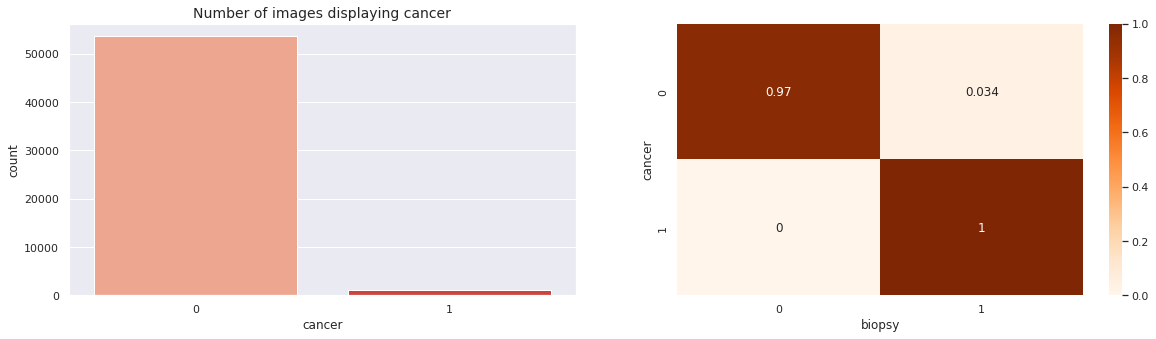

In [36]:
(fig, ax) = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(train_df.cancer, palette='Reds', ax=ax[0])
ax[0].set_title('Number of images displaying cancer', size=14)
sns.heatmap(biopsy_perc.transpose(), ax=ax[1], annot=True,
            cmap='Oranges')

### Remarks

* The number of images displaying cancer is very low. It should be even of lower percentage than the number of patients with cancer. 
* Looking at the biopsy feature we can say that all patients with cancer had a biopsy. But only around 3 % of images without cancer had resulted in a follow-up biopsy. We should better have a look at this feature on the patient-level. 

In [37]:
round(train_df.cancer.value_counts()/train_df.shape[0]*100,2)

0    97.88
1     2.12
Name: cancer, dtype: float64

In [38]:
round(patient_cancer_map.value_counts() / patient_cancer_map.shape[0]*100,2)

False    95.92
True      4.08
Name: cancer, dtype: float64

As expected, the percentage of patients with cancer is higher than the percentage of images displaying cancer. How many images show invasive cancer that has spread beyond the layer of tissue in which it developed?

<AxesSubplot:xlabel='BIRADS', ylabel='count'>

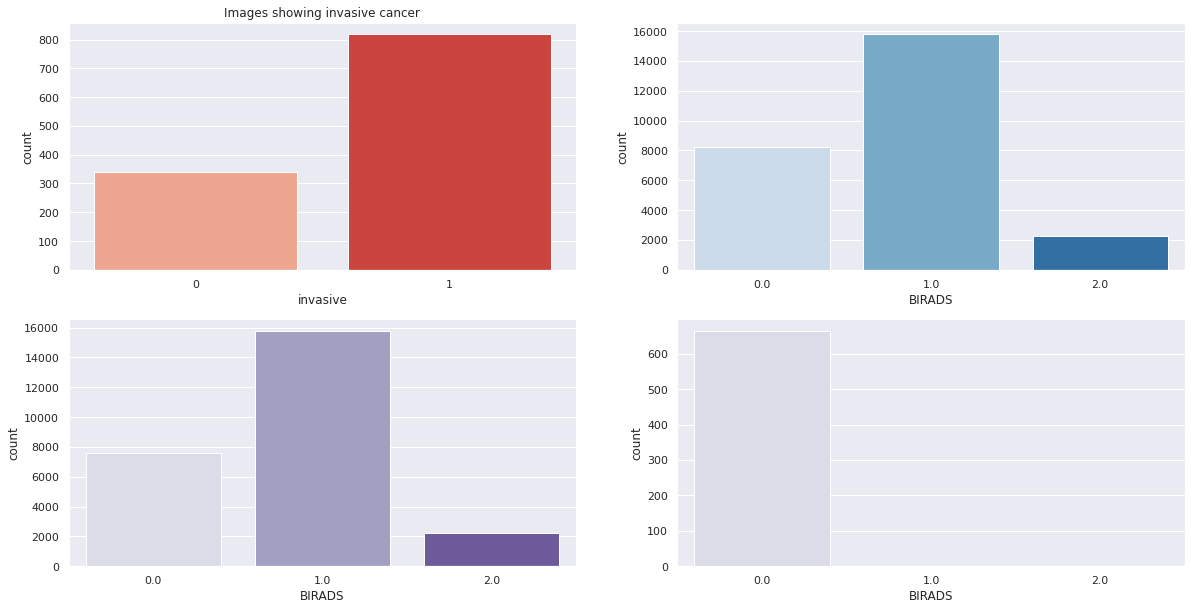

In [39]:
(fig, ax) = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(train_df[train_df.cancer == 1].invasive, ax=ax[0, 0],
              palette='Reds')
sns.countplot(train_df.BIRADS, order=[0., 1., 2.], ax=ax[0, 1],
              palette='Blues')
ax[0, 0].set_title('Images showing invasive cancer')

sns.countplot(train_df[train_df.cancer == 0].BIRADS, order=[0., 1.,
              2.], ax=ax[1, 0], palette='Purples')
sns.countplot(train_df[train_df.cancer == 1].BIRADS, order=[0., 1.,
              2.], ax=ax[1, 1], palette='Purples')

In [40]:
round(train_df[train_df.cancer == 1].invasive.value_counts()
      / train_df[train_df.cancer == 1].shape[0] * 100, 2)

1    70.64
0    29.36
Name: invasive, dtype: float64

### Remarks

* ~70 % of all images displaying cancer are showing invasive cancer thus the one that spreads into other tissues as well.
* For BIRADS we need to remember that its value is
    * 0 if the breast required follow-up
    * 1 if the breast was rated as negative for cancer 
    * 2 if the breast was rated as normal
* Given that information, we can see that most images were rated as negative which suites to the fact that most images are not positive for cancer. But nonetheless there is still a high number of images that lead into a follow-up. What's the difference between 1 and 2? From the ordering I would suspect that 2 is better than 1. 
* Going one level deeper and showing the BIRADS counts for 'no cancer'-images and 'cancer'-images, we can at least say that all images showing cancer needed a follow up.

## Machine Ids <a class="anchor" id="machine_ids"></a>

How many different imaging devices were used?

In [41]:
print('The number of machines used:', train_df.machine_id.nunique())

The number of machines used: 10


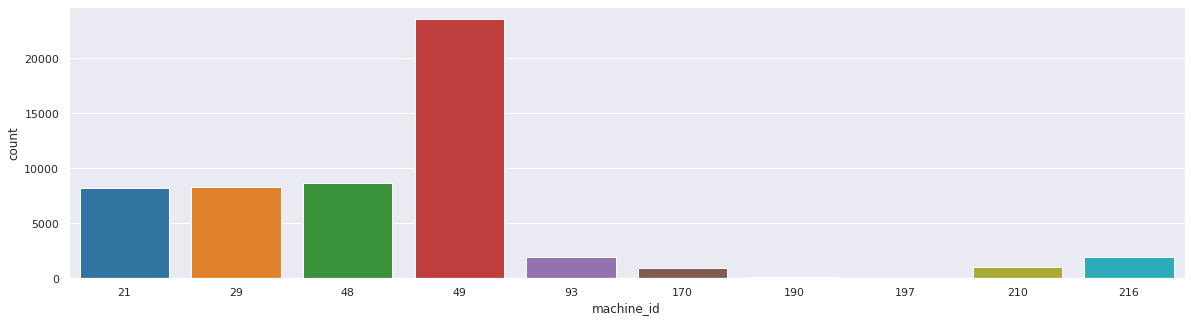

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train_df.machine_id, palette='tab10', ax=ax);

### Remarks

* 10 different machines but most of the images were take with device of id 49, 21, 29 and 48. 
* How important is this feature for the prediction of cancer?

# Exploring the images <a class="anchor" id="images"></a>

Browsing through the train and test folder of the images, we can see that the data is given as dicom files.

**What is a DICOM Image File?**

All modalities in radiology practice have become digital, and therefore deal with DICOM images.

A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc. For more detail to how to explore data [see](https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing) this notebook.


In [43]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

First of all, we need a method to get all scans of one patient:

In [44]:
def load_scans(path, patient_id):
    """Get all scans of one patient.

    Args:
        f: path.
    Returns:
        patient_id.
        
    """
    dcm_path = path + str(patient_id)
    scans = [pydicom.dcmread(dcm_path + '/' + file, force=True)
             for file in listdir(dcm_path)]
    return scans

## Pixelarray distributions <a class="anchor" id="raw values"></a>

* Usually we need to transform the raw pixelarray distributions to Hounsfield Units. The raw values depend on the measurement settings like acquisition parameters and tube voltage of the scanner. 
* By normalizing to values of water and air (water has HU=0 and air=-1000) the images of different measurements are becoming comparable. 
* We also need to understand how background values were treated!

Let's load an example:

In [45]:
patient_ids = train_df.patient_id.unique()

In [46]:
scans = load_scans(train_path, patient_ids[0])

And let's plot the raw pixelarray distribution for this example and display the related image:

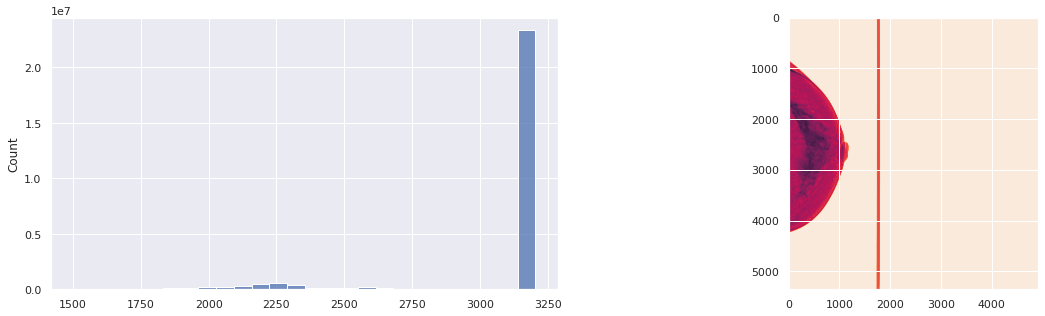

In [47]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(scans[0].pixel_array.flatten(), ax=ax[0])
ax[1].imshow(scans[0].pixel_array)

### Remarks

* The background seems to be above 3000.
* As the raw values depend on the machine, it could be worth to explore background values dependent on the machine id. 

Let's get an impression by extracting the mode per scan for a few patients for each machine id.

In [48]:
machine_ids = train_df.machine_id.unique()
machine_ids

array([ 29,  21, 216,  93,  49,  48, 170, 210, 190, 197])

In [49]:
scans[0].Columns

4915

## Background values and image sizes <a class="anchor" id="mid_dependence"></a>

In [50]:
background_values = []
rows = []
columns = []
for mid in tqdm(train_df.machine_id.unique()):
    mid_background_values = []
    mid_rows = []
    mid_columns = []

    print(f'Machine id {mid}:')

    for n in range(50):  # number of patients = 50
        try:
            scans = load_scans(train_path, train_df[train_df.machine_id
                               == mid].patient_id.unique()[n])
            mid_background_values.append(mode(scans[0].pixel_array.flatten())[0][0])
            mid_rows.append(scans[0].Rows)
            mid_columns.append(scans[0].Columns)
        except IndexError:
            break
    background_values.append(mid_background_values)
    rows.append(mid_rows)
    columns.append(mid_columns)

  0%|          | 0/10 [00:00<?, ?it/s]

Machine id 29:


 10%|█         | 1/10 [02:16<20:31, 136.86s/it]

Machine id 21:


 20%|██        | 2/10 [02:49<10:05, 75.70s/it] 

Machine id 216:


 30%|███       | 3/10 [03:14<06:06, 52.42s/it]

Machine id 93:


 40%|████      | 4/10 [03:49<04:34, 45.69s/it]

Machine id 49:


 50%|█████     | 5/10 [04:55<04:24, 52.90s/it]

Machine id 48:


 60%|██████    | 6/10 [06:20<04:15, 63.76s/it]

Machine id 170:


 70%|███████   | 7/10 [07:22<03:10, 63.36s/it]

Machine id 210:


 80%|████████  | 8/10 [09:35<02:50, 85.30s/it]

Machine id 190:


 90%|█████████ | 9/10 [09:49<01:03, 63.11s/it]

Machine id 197:


100%|██████████| 10/10 [09:52<00:00, 59.21s/it]


In [51]:
for i in range(len(background_values)):
    print (
        'Machine_id:',
        machine_ids[i],
        ';',
        'Median:',
        np.median(background_values[i]),
        ';',
        'Std:',
        round(np.std(background_values[i]), 1),
        )

Machine_id: 29 ; Median: 3524.0 ; Std: 215.8
Machine_id: 21 ; Median: 0.0 ; Std: 0.0
Machine_id: 216 ; Median: 0.0 ; Std: 146.7
Machine_id: 93 ; Median: 0.0 ; Std: 289.5
Machine_id: 49 ; Median: 0.0 ; Std: 0.0
Machine_id: 48 ; Median: 0.0 ; Std: 0.0
Machine_id: 170 ; Median: 0.0 ; Std: 0.0
Machine_id: 210 ; Median: 1017.0 ; Std: 2.2
Machine_id: 190 ; Median: 0.0 ; Std: 67.8
Machine_id: 197 ; Median: 83.5 ; Std: 219.3


### Remarks

* It depends on the machine id, how background values are treated. In most of the cases they seem to be 0. But for id 29 it's above 3000 and for id 210 it seems to be 1017. 
* Id 197 looks interesting. Currently I don't know, what it means. Let's take a look at the values

In [52]:
background_values[-1]

[0, 537, 0, 167]

Only 4 patients and it could be that the background values for patient 2 and 4 are not the same as the mode.

What about the image sizes? Are they also dependent on the machine id? Let's have a look at the columns and the rows:

In [53]:
for i in range(len(columns)):
    print(i)
    print(f"Machine id {train_df.machine_id.unique()[i]}, unique columns: {np.unique(columns[i])}")

0
Machine id 29, unique columns: [4915]
1
Machine id 21, unique columns: [2082]
2
Machine id 216, unique columns: [1914]
3
Machine id 93, unique columns: [1914 2394]
4
Machine id 49, unique columns: [2560 3328]
5
Machine id 48, unique columns: [3328]
6
Machine id 170, unique columns: [2560 3328]
7
Machine id 210, unique columns: [3540 4728]
8
Machine id 190, unique columns: [1914 2394]
9
Machine id 197, unique columns: [1022 1914 2045 2394]


In [54]:
for i in range(len(rows)):
    print(f"machine id {train_df.machine_id.unique()[i]}, unique rows: {np.unique(rows[i])}")

machine id 29, unique rows: [5355]
machine id 21, unique rows: [2776]
machine id 216, unique rows: [2294]
machine id 93, unique rows: [2294 3062]
machine id 49, unique rows: [3328 4096]
machine id 48, unique rows: [4096]
machine id 170, unique rows: [3328 4096]
machine id 210, unique rows: [4740 5928]
machine id 190, unique rows: [2294 3062]
machine id 197, unique rows: [1236 2294 2473 2850]


The image size depends on the machine id as well. It's interesting to take a look at a single dicom file to look for further features:

In [55]:
mid = train_df.machine_id.value_counts().index.values[0]
mid

49

In [56]:
mid_patients = train_df[train_df.machine_id == mid].patient_id.unique()
scans = load_scans(train_path, mid_patients[10])
len(scans)

4

### Remarks

* The sizes of the dicom images as well as the background values depend on the machine id.
* Besides that there are further features that may also have this dependency.
* We also found a few machine ids that have some variability inside their group (like images with two different sizes or a few possible background values).

## Exploring dicom images <a class="anchor" id="mid_49"></a>

Let's keep it simple for now by making the assumption that all files with the same machine id share similar or same features. Then we could try to explore more (probably visual) patterns within one machine id group. The largest one belongs to id 49. 

In [57]:
train_df[train_df.machine_id==49].shape

(23529, 14)

In [58]:
train_df[train_df.machine_id==49].patient_id.nunique()

4589

4589 patients in that group! Maybe it's sufficient to explore the images given a resized and transformed dataset with png-images of size 256x256. for more details see [this](https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg).

##  Generating & recising Images from dicom format <a class="anchor" id="mid_49"></a>

In [59]:
train_images = \
    glob.glob('/kaggle/input/rsna-breast-cancer-detection/train_images/*/*.dcm'
              )

len(train_images)

54706

## Examples

  0%|          | 0/4 [00:00<?, ?it/s]

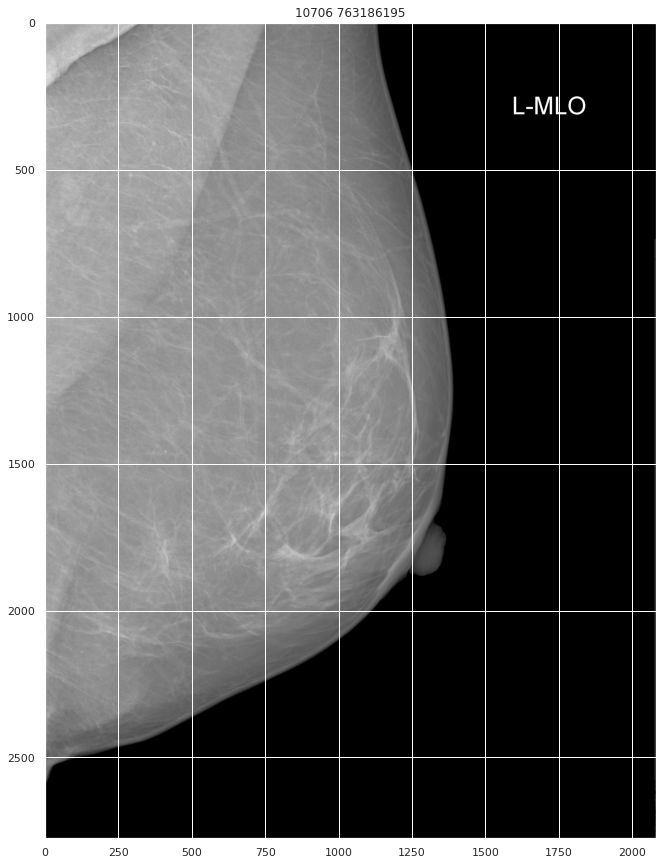

 25%|██▌       | 1/4 [00:01<00:04,  1.51s/it]

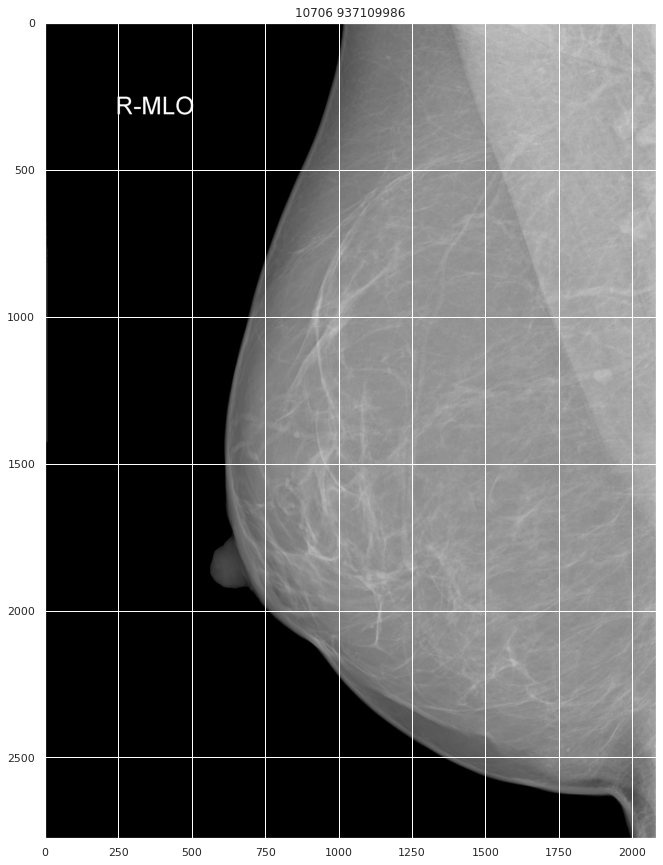

 50%|█████     | 2/4 [00:02<00:02,  1.48s/it]

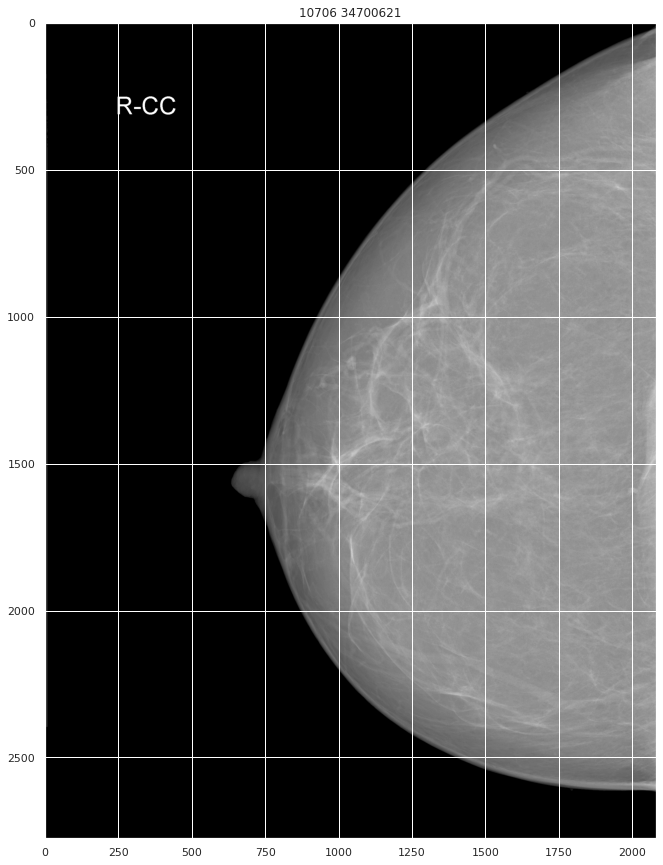

 75%|███████▌  | 3/4 [00:04<00:01,  1.43s/it]

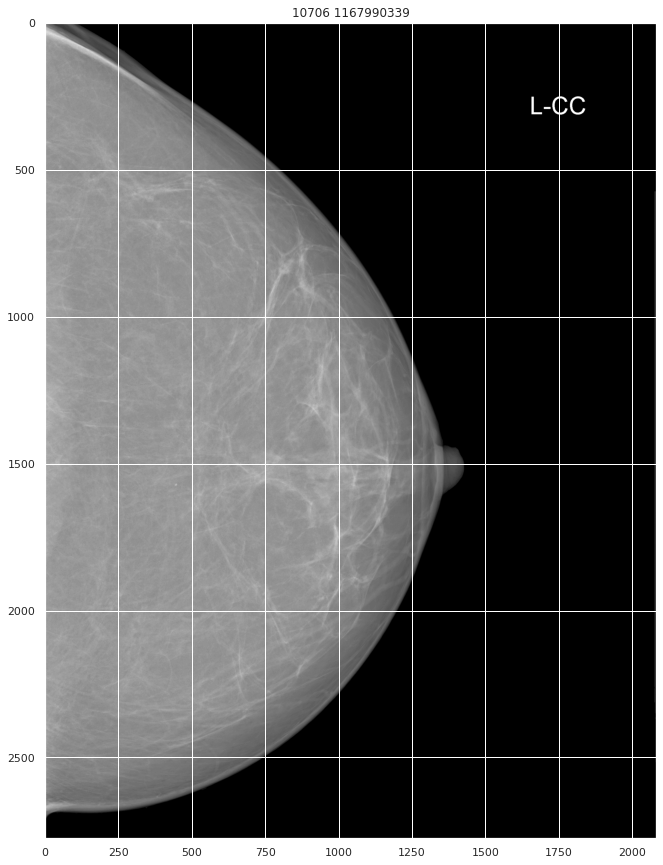

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


In [60]:
for f in tqdm(train_images[:4]):
    patient = f.split('/')[-2]
    image = (f.split('/')[-1])[:-4]

    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        img = 1 - img

    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap='gray')
    plt.title(f"{patient} {image}")
    plt.show()

## Save the processed data

Images are quite big so resizing them is necessary.

We will use the size 256x256 to train our first models, and to reduce computation time.

We use the png format because the jpg compression can be annoying during inference.

In [61]:
SAVE_FOLDER = "output/"
SIZE = 256
EXTENSION = "png"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [62]:
def process(
    f,
    size=256,
    save_folder='',
    extension='png',
    ):
    """process of train images.

    Args:
        f: train_images.
        size: size of image
        save_folder:
        extension: extension of image
        
    """
    patient = f.split('/')[-2]
    image = (f.split('/')[-1])[:-4]

    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())
    

    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        img = 1 - img

    img = cv2.resize(img, (size, size))


    cv2.imwrite(save_folder + f"{patient}_{image}.{extension}", (img * 255).astype(np.uint8))


In [63]:
_ = Parallel(n_jobs=4)(
    delayed(process)(uid, size=SIZE, save_folder=SAVE_FOLDER, extension=EXTENSION)
    for uid in tqdm(train_images[:50])
)

100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


In [64]:
train_df['png_256_path'] = '/kaggle/input/rsna-breast-cancer-256-pngs/' \
    + train_df.patient_id.astype(str) + '_' \
    + train_df.image_id.astype(str) + '.png'

In [65]:
means = []
medians = []
stds = []
skews = []
paths = []
targets = []

patients_49 = train_df[train_df.machine_id == 49].patient_id.unique()

for i in range(len(patients_49)):
    pid = patients_49[i]
    path = train_df[(train_df.machine_id == 49) & (train_df.patient_id
                    == pid)].png_256_path.values[0]
    targets = train_df[(train_df.machine_id == 49)
                       & (train_df.patient_id == pid)].cancer.values[0]
    paths.append(path)
    image = Image.open(path)
    means.append(np.mean(image))
    medians.append(np.median(image))
    stds.append(np.std(image))
    skews.append(skew(image, axis=None))

In [66]:
stats_49 = pd.DataFrame(means, index=patients_49, columns=['means'])
stats_49['stds'] = stds
stats_49['medians'] = medians
stats_49['skews'] = skews
stats_49['paths'] = paths
stats_49['cancer'] = targets

In [67]:
fig = px.scatter_3d(stats_49, x='means', y='stds', z='skews',
                    color='medians')
fig.show()

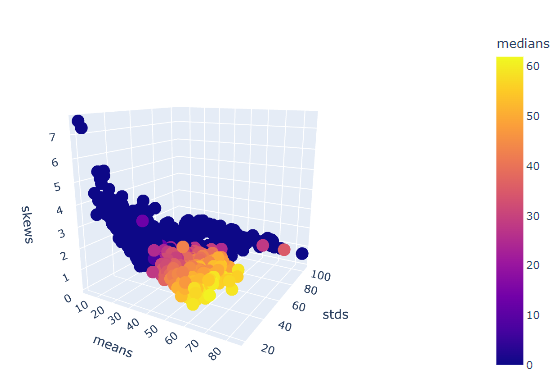

### Remarks

* Given the image statistics we would say that there are at least four groups. 
* One group has large median values, small stds, high mean values and low skewness. 
* Second groupd is very dense with low means and stds but low to high skewnesses. 
* The thrid group shows high mean values and stds, but low skewness. 
* The last group has low values for all features.

Let's cluster that a bit to explore different visual patterns:

In [68]:
scaler = StandardScaler()
X = stats_49.drop(['paths', 'cancer'], axis=1).values
X = scaler.fit_transform(X)

In [69]:
gmm = GaussianMixture(n_components=4, random_state=0)
stats_49["cluster_label"] = gmm.fit_predict(X)

In [70]:
fig = px.scatter_3d(stats_49, x='means', y='stds', z='skews',
                    color='cluster_label')
fig.show()

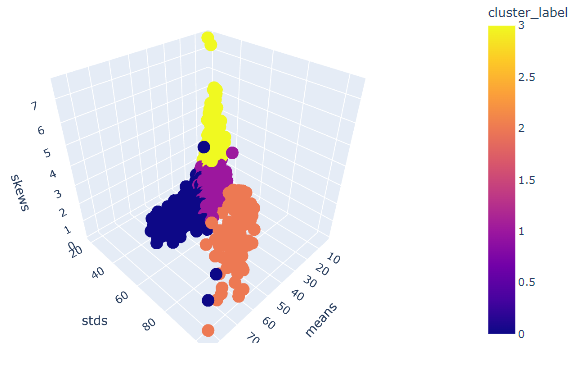

Let's take a look at the different images per cluster label:

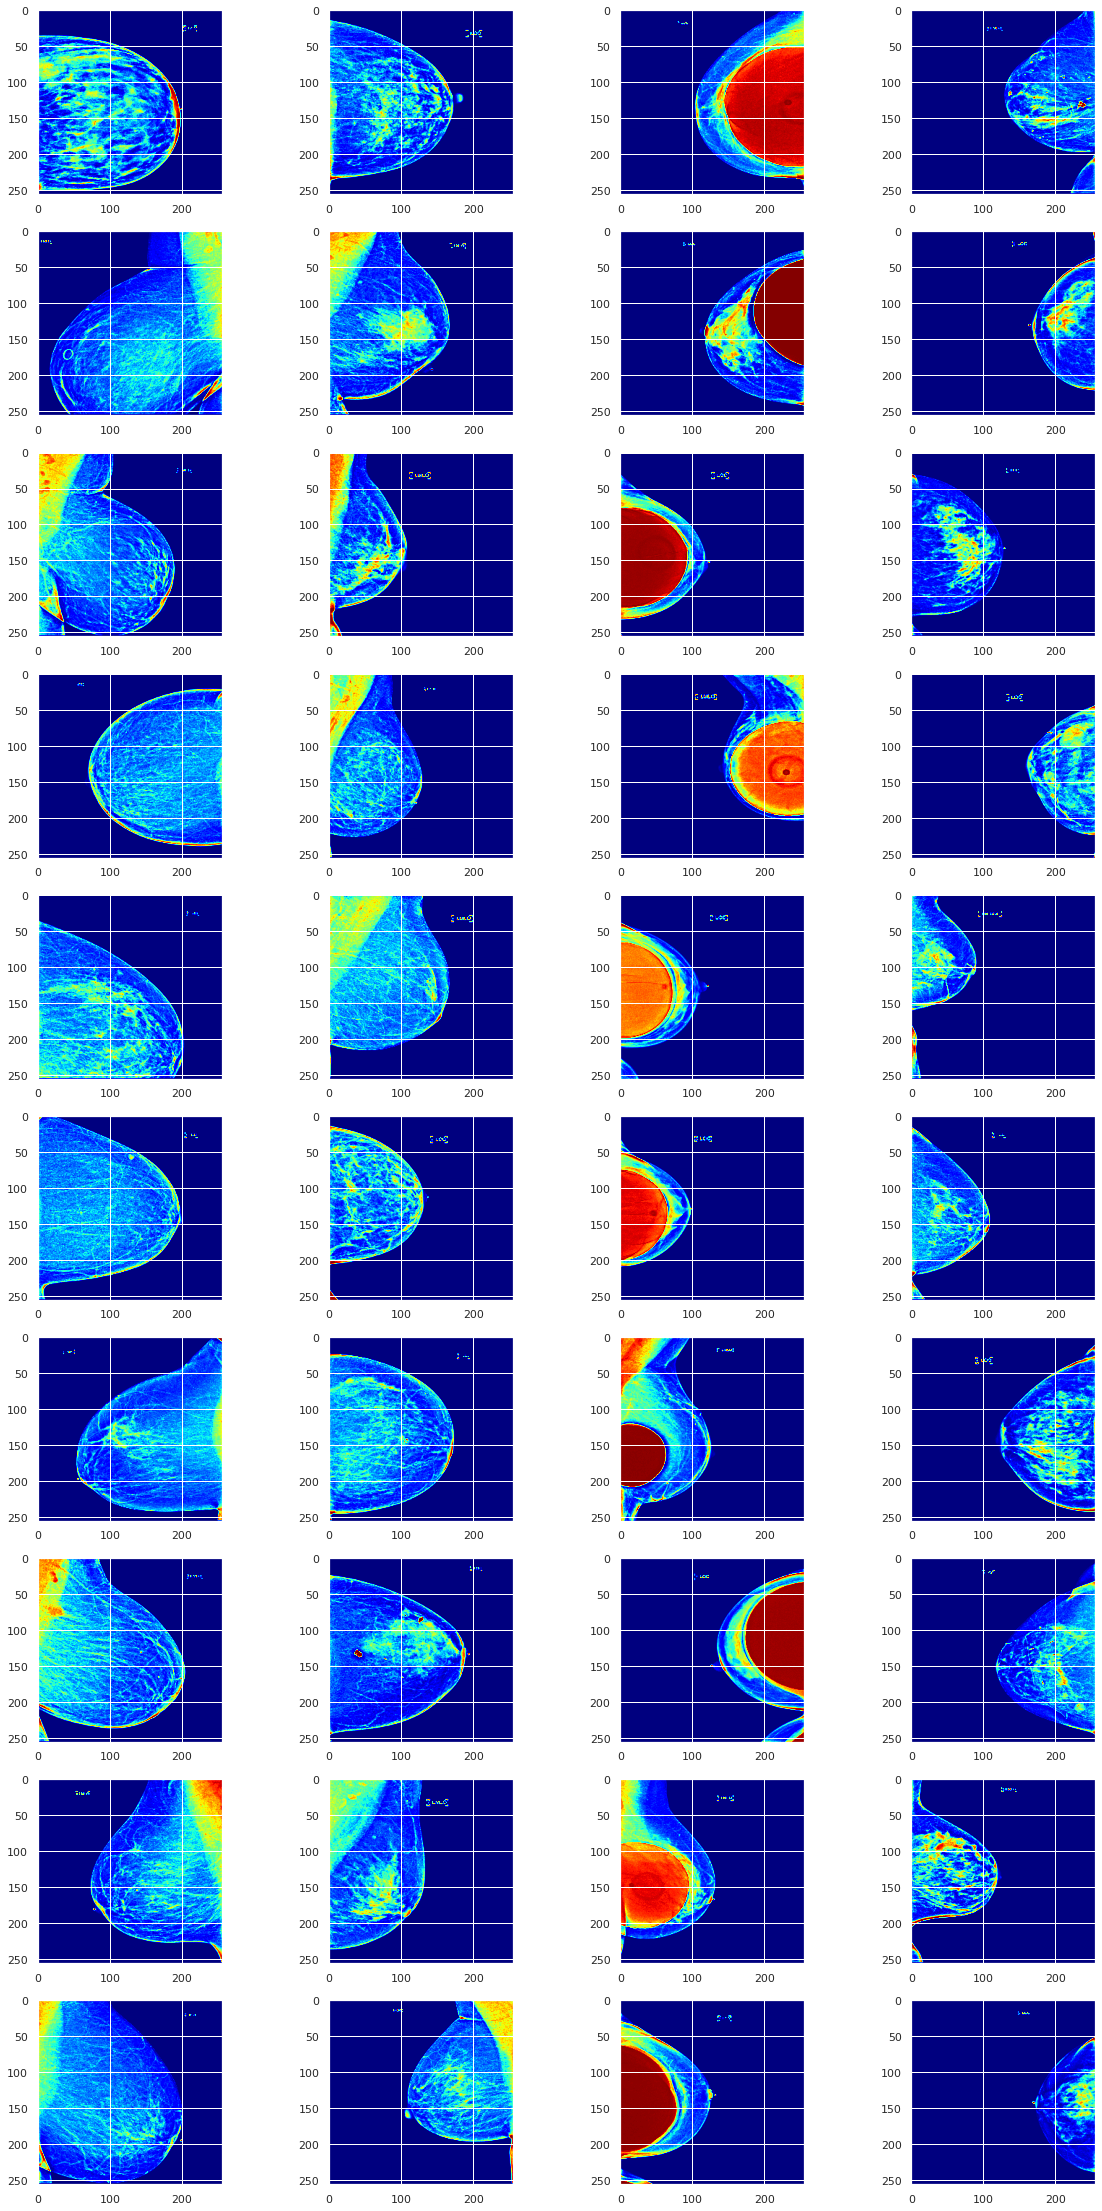

In [71]:
(fig, ax) = plt.subplots(10, 4, figsize=(20, 40))
for i in range(4):
    img_paths = stats_49[stats_49.cluster_label == i].paths.values[0:10]
    for n in range(10):
        try:
            image = Image.open(img_paths[n])
            ax[n, i].imshow(image, cmap='jet')
        except:
            ax[n,i].set_title(f"label {l}")
            continue
        ax[n, i].axis('off')

In [72]:
np.unique(stats_49.cancer)

array([0])

### Remarks

* The group with high median values stands out most. We can see that there are large regions within the breast with high intensity values. And it's not cancer!
* In contrast the other images vary mainly in the amount of background values and still look very similar. 

In [73]:
high_intensity_patients = stats_49[stats_49.cluster_label==2].index.values

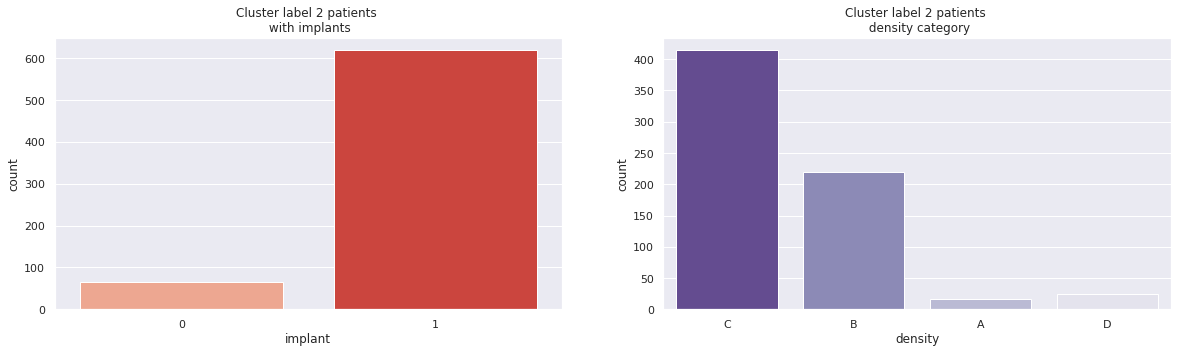

In [74]:
selection = train_df[train_df.patient_id.isin(high_intensity_patients)]


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(selection.implant, ax=ax[0], palette='Reds')
sns.countplot(selection.density, ax=ax[1], palette='Purples_r')
ax[0].set_title('Cluster label 2 patients \n with implants');
ax[1].set_title('Cluster label 2 patients \n density category');

Most of these images show implants! :-)

In [75]:
round(train_df[train_df.implant
      == 1].difficult_negative_case.value_counts()
      / train_df[train_df.implant == 1].shape[0] * 100, 2)

False    81.52
True     18.48
Name: difficult_negative_case, dtype: float64

In [76]:
round(train_df[train_df.implant
      == 0].difficult_negative_case.value_counts()
      / train_df[train_df.implant == 0].shape[0] * 100, 2)

False    86.04
True     13.96
Name: difficult_negative_case, dtype: float64

## Exploring outliers <a class="anchor" id="outliers"></a>

In [77]:
stats_49['logL'] = gmm.score_samples(X)

In [78]:
stats_49.logL.quantile(q=0.01)

-8.355624556481349

In [79]:
outliers = stats_49[stats_49.logL < -10].sort_values(by='logL')
len(outliers)

32

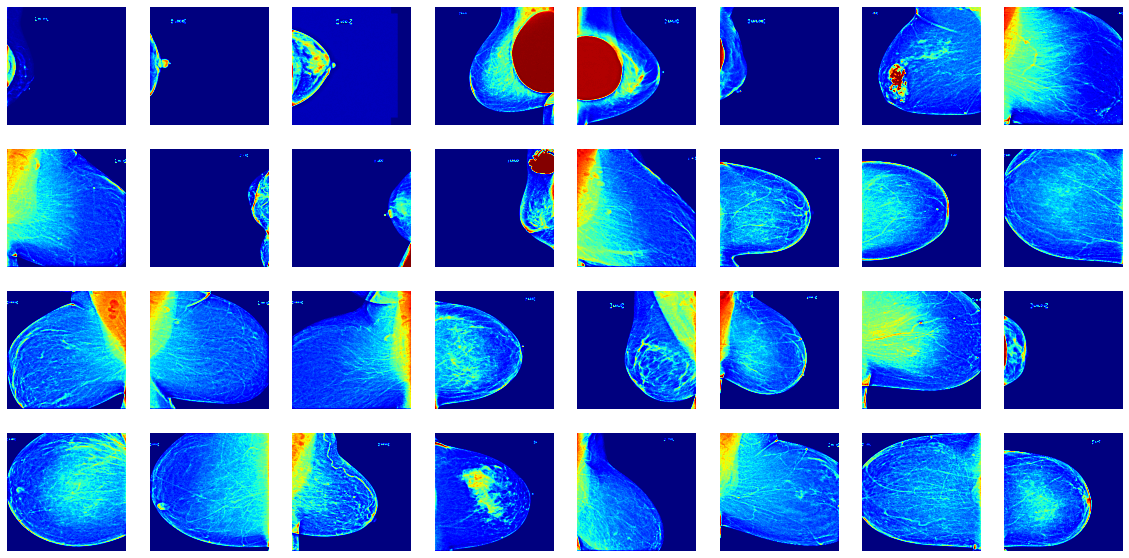

In [80]:
(fig, ax) = plt.subplots(4, 8, figsize=(20, 10))
for n in range(4):
    for m in range(8):
        image = Image.open(outliers.paths.values[8 * n + m])
        ax[n, m].imshow(image, cmap='jet')
        ax[n, m].axis('off')

We should expect both - cases with the whole image covered with breast and images with almost no tissue at all. Furthermore we will have some cases with some kind of artifacts like the thrid one in the first row that shows different background values separated by a sharp edge. Most likely there will be other outliers as well that we will not be able to find with the simple method of using image statistics. 

## Exploring images with cancer <a class="anchor" id="cancer"></a>

Last but not least I would like to explore some dicom images with cancer and to ensure that dicom files are similar I will continue with machine id 49. 

In [81]:
selection = train_df[(train_df.machine_id == 49) & (train_df.cancer == 1)]
selection.head()

site_id patient_id    image_id laterality view   age  cancer  biopsy  \
87        1      10130   388811999          L  MLO  71.0       1       1   
88        1      10130   613462606          L   CC  71.0       1       1   
89        1      10130  1360338805          L   CC  71.0       1       1   
90        1      10130  1672636630          L  MLO  71.0       1       1   
190       1      10226   461614796          L  MLO  71.0       1       1   

     invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
87          1     0.0        0       B          49                    False   
88          1     0.0        0       B          49                    False   
89          1     0.0        0       B          49                    False   
90          1     0.0        0       B          49                    False   
190         1     0.0        0       C          49                    False   

                                          png_256_path  
87   /kaggle/input/rsna-breast-cancer-256-pngs/1013...  
88   /kaggle/input/rsna-breast-cancer-256-pngs/1013...  
89   /kaggle/input/rsna-breast-cancer-256-pngs/1013...  
90   /kaggle/input/rsna-breast-cancer-256-pngs/1013...  
190  /kaggle/input/rsna-breast-cancer-256-pngs/1022...

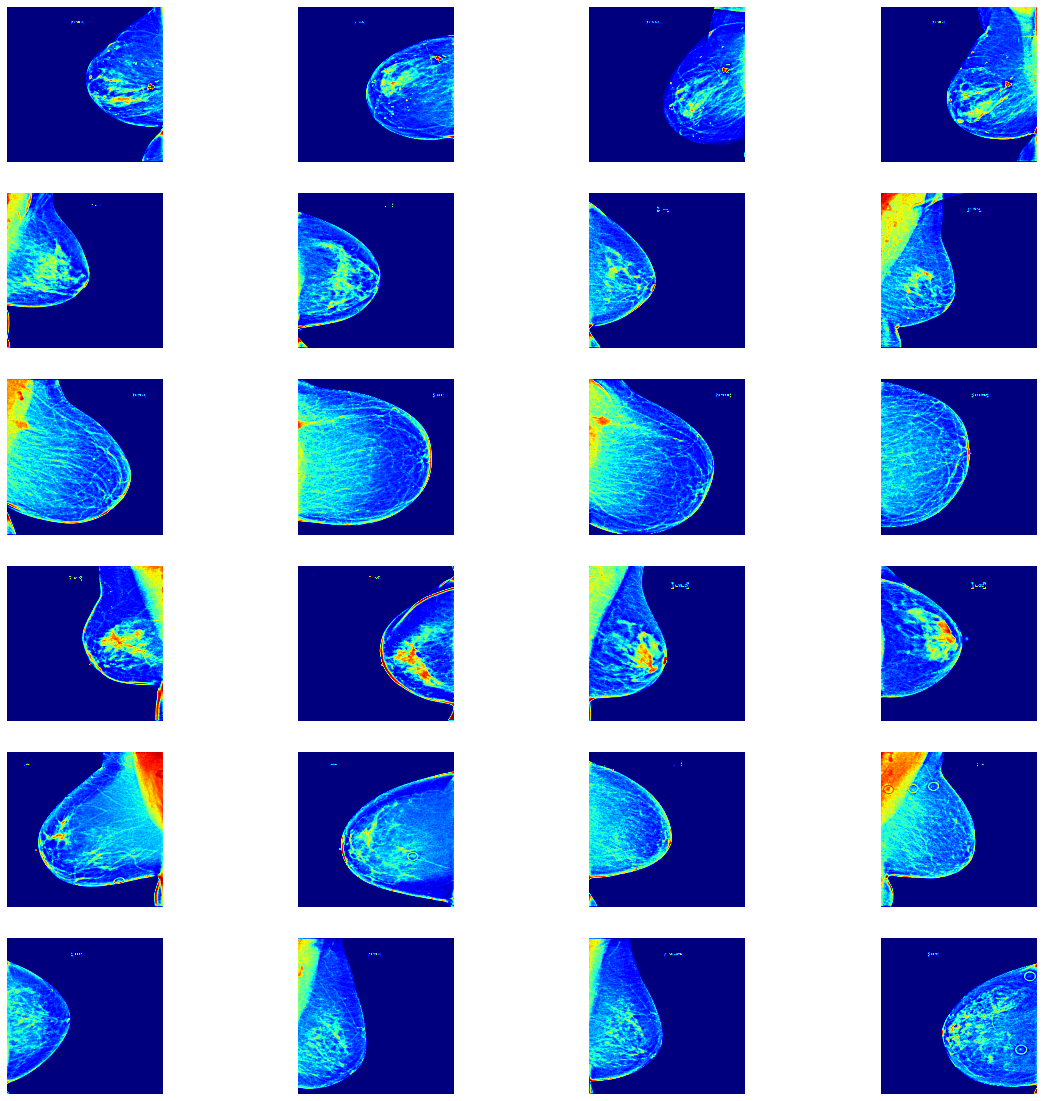

In [82]:
N = 4
M = 6
(fig, ax) = plt.subplots(M, N, figsize=(20, 20))
for m in range(M):
    for n in range(N):
        image = Image.open(selection.png_256_path.values[N * m + n])
        ax[m, n].imshow(image, cmap='jet')
        ax[m, n].axis('off')

# Conclusion <a class="anchor" id="conclusion"></a>


* We are asked to solve an unbalanced classification problem with only ~2% of images showing cancer.
* Most patients have 4 images with the left and right breast in combination with the two default views CC and MLO. But there are some exceptions to this rule with more images and more views.
* How the raw values of the dicom pixel array should be preprocessed depends on the machine ID! The background values have been treated differently.
* Most images (~70%) with cancer show invasive cancer.
* Image sizes also depend on machine ID!